# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [14]:
# import libraries
import os
import sys
import sklearn
import nltk
import re
import pickle 
import joblib
# import dill as joblib 

import numpy as np
import pandas as pd
from pprint import pprint
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

#help(sklearn.multioutput)
# help(sklearn)

from sklearn.base import BaseEstimator
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import FeatureUnion,Pipeline


#help(sklearn.metrics)
#help(sklearn.multioutput)

# Download the stopwords and all nltk relevant packages.
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/emmanuele/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emmanuele/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emmanuele/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/emmanuele/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/emmanuele/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/emmanuele/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [13]:
def load_data(
    database_path="../data/DisasterResponse.db",
    x_column_name = "message", 
    y_start=4, 
    y_stop=None, 
    table_name='cleandata'
    ):
    """
    Fetch cleaned data from an sqlite database and return as 
    pandas data frame.

    Args:
       x_column_name (str): Name of the column in the dataset table
                             for input features (default is 'message').
        y_start (int): The starting index for the target columns (default is 4).
        y_stop (int or None): The stopping index for the target columns.
                              If None, all columns from y_start onward will be 
                              selected (default is None).
        table_name (str): Name of the table in the database containing the dataset
                          (default is 'cleandata').
        database_path (str): Relative path to the database file containing the 
                             cleaned dataset (default is 'DisasterTweets.db').
    
    Returns:
        X (numpy.ndarray): Input feature data.
        y (numpy.ndarray): Target output data.
        df (pandas.DataFrame): DataFrame containing both input features and target outputs.
    """
    conn_engine = create_engine("sqlite:///"+database_path)
    # Load data from a specific table into a DataFrame
    df = pd.read_sql_table(table_name, con=conn_engine)
    # Extract the input feature column
    X = df[x_column_name]
    # Extract the target columns
    if y_stop == None:
        y = df.iloc[:,y_start:]
    else:
        y = df.iloc[:, y_start:y_stop] 
    classes = list(y.columns)
    return X.values, y.values, classes

In [12]:
def audit_data(x_train, y_train, class_names, x_test=None, y_test=None):
    """
    Performs a comprehensive audit of machine learning dataset properties and types.
    
    Args:
        x_train(numpy.ndarray): Training features
        y_train(numpy.ndarray): Training labels
        class_names(list): list of all class names in the output dataset.
        x_test(numpy.ndarray): Test features -- optional
        y_test(numpy.ndarray): Test labels -- optional
        
    Returns:
        data_info(pd.DataFrame) : Pandas data frame containing data category, 
                                shape and type info.
    """
    print("-"*100)
    print("Dataset Audit Report")
    
    # View the first few rows of the DataFrame
    x_df = pd.DataFrame(x_train)
    y_df = pd.DataFrame(y_train)
    x_df.columns =["input_features"]
    y_df.columns = list(class_names)
    display(x_df.head(3))
    display(y_df.head(3))

    data_info = {
        "data":[],
        "type":[],
        "shape":[]
    }
    
    data_info['data'].append('X_train')
    data_info['type'].append(type(x_train))
    data_info['shape'].append(x_train.shape)
    data_info['data'].append('y_train')
    data_info['type'].append(type(y_train))
    data_info['shape'].append(y_train.shape)
    
    
    if x_test is not None and y_test is not None:
        data_info['data'].append('X_test')
        data_info['type'].append(type(x_test))
        data_info['shape'].append(x_test.shape)
        data_info['data'].append('y_test')
        data_info['type'].append(type(y_test))
        data_info['shape'].append(y_test.shape)
    
    data_info = pd.DataFrame(data_info)
    display(data_info)

    # Dataframe column of class names in the dataset.
    class_df = pd.DataFrame({"labels": class_names})
    
    # Count occurrences of each class label in the training data.
    class_freq = []
    for index in range(len(class_names)):
        class_count = np.sum(y_train[:,index])
        class_freq.append(class_count)
    
    # Create a DataFrame with counts for each class in the training data
    # Add the category/class names as a column

    train_data_distr = pd.DataFrame({
        "labels": class_names,
        "no. of samples(Train Data)": class_freq    
    })
    
    data_distr_df = train_data_distr
    
    if x_test is not None and y_test is not None:
        # Count occurrences of each class label in the test data.
        class_freq = []
        for index in range(len(class_names)):
            class_count = np.sum(y_test[:,index])
            class_freq.append(class_count)
        
        # Create a DataFrame with counts for each class in the test data
        # Add the category/class names as a column

        test_data_distr = pd.DataFrame({
            "labels": class_names,
            "no. of samples(Test Data)": class_freq    
        })
        
        data_distr_df = pd.concat([data_distr_df, test_data_distr.iloc[:,1:]], axis=1)
    
    if 'ipykernel' in sys.modules:
        # Running in a Jupyter Notebook.
        print("-"*100)
        print("Data Distribution in Dataset:")
        display(data_distr_df)

    else:
        # Not running in a Jupyter Notebook.
        print("-"*100)
        print("Data Distribution in Dataset:")
        print(data_distr_df)  
    
    print("\n")
            
    return data_info        

In [11]:

def calculate_multiclass_accuracy(y_true, y_pred):
    """
    Calculate accuracy for multi-class classification
    
    Args:
        y_test(numpy.ndarray): actual output data.
        y_pred(numpy.ndarray): predicted output data as returned by our model,
                              classifier.
    
    Returns:
        summary_accuracy_score(float): summary accuracy using decoded labels.
    """
    # Convert to labels if one-hot encoded
    if (len(y_true.shape) > 1) & (len(y_pred.shape) > 1):
        # Initialize an empty list to store per-column accuracy
        accuracies = []

        # Iterate over each column (class output)
        for col in range(y_true.shape[1]):
            # Compute accuracy for the current column
            col_accuracy = accuracy_score(y_true[:, col], y_pred[:, col])
            accuracies.append(col_accuracy)

        # Average accuracy across all columns
        summary_accuracy_score = np.mean(accuracies)
       
    else:
        print("Empty values for y test or y pred")
        summary_accuracy_score = np.nan
    
    return summary_accuracy_score


def per_class_accuracy(y_true, y_pred, class_names):
    """
    Calculate accuracy for each class separately

    Args
        y_test(numpy.ndarray): actual output data.
        y_pred(numpy.ndarray): predicted output data as returned by our model,
                              classifier.
        class_names (list): list of all class names in the output dataset.
    
    return
        accuracies_df (pd.DataFrame): a dataframe of class names 
        and their correspoinding accuracy score for binary classification
    
    """
    accuracies = []
    for i in range(len(class_names)):
        class_data_true = y_true[:, i]
        class_data_pred = y_pred[:, i]
        if (class_data_true.shape[0] > 0) & (class_data_pred.shape[0] > 0):
            class_acc = accuracy_score(class_data_true, class_data_pred)
            accuracies.append(class_acc)
            
        else:
            print("Empty values for y test or y pred")
            class_acc = np.nan
            accuracies.append(class_acc)
            
    
    accuracies_df = pd.DataFrame({"category":class_names, "accuracy":accuracies})
    return accuracies_df
    

def evaluate_multilabel_model(y_true, y_pred, class_names):
    """
    Comprehensive evaluation of a multi-label classification model.
    
    Args:
        y_test (numpy.ndarray): actual output data.
        y_pred (numpy.ndarray): predicted output data as returned by our model,
                              classifier.
        class_names (list): list of all class names in the output dataset.
        
    return
        metrics_df(pd.DataFrame): a dataframe of class names 
                              and their correspoinding precision, recall and 
                              F1-score values, for binary classification
    """
    average_accuracy = calculate_multiclass_accuracy(y_true, y_pred)
    print(f"Overall Sample-wise Accuracy: {average_accuracy:.3f}")
    print("-"*100)

    # Calculate per-class accuracy
    accuracies_df = per_class_accuracy(y_true, y_pred, class_names)

    # Per-class classification metrics
    classification_metrics = []
    reports = {}
    for i in range(y_true.shape[1]):
        if np.sum(y_true[:, i]) > 0:  # Check if there are true instances
            precision = precision_score(y_true[:, i], y_pred[:, i], average='macro', zero_division=0)
            recall = recall_score(y_true[:, i], y_pred[:, i],average='macro', zero_division=0)
            f1 = f1_score(y_true[:, i], y_pred[:, i],average='macro', zero_division=0)
        
            classification_metrics.append({
                'Class': class_names[i],
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            })
        
            
            report_dict = classification_report(y_true[:, i], y_pred[:, i], zero_division=0, output_dict=True)
            report_df = pd.DataFrame(report_dict).transpose()
            report_df = report_df.round(3)
            report_log = None
            reports[class_names[i]]=[report_df, report_log]
            
        else:
            classification_metrics.append({
                'Class': class_names[i],
                'Precision': np.nan,
                'Recall': np.nan,
                'F1-Score': np.nan
            })
            report_df = None
            reports_log = f"\nFound No true instances for {class_names[i]}. Ommitted from report\n"
            reports[class_names[i]]=[report_df, reports_log]
            
    # Create a DataFrame with a summary classification metrics per class.
    classification_metrics_df = pd.DataFrame(classification_metrics)
    print("\nSummary of all metrics:")
    print("-"*100)
    metrics_df = pd.concat([accuracies_df, classification_metrics_df.iloc[:,1:]], axis=1).round(3)
    
    if 'ipykernel' in sys.modules:
        # Running in a Jupyter Notebook.
        display(metrics_df.round(3))

    else:
        # Not running in a Jupyter Notebook.
        print(metrics_df.round(3))
        
    
    print('Detailed classification report per class')
    print("-"*100)
    for class_name in reports.keys():
        print(f"\nDetailed metrics for {class_name}:")
        report_df = reports[class_name][0]
        if report_df is not None:
            if 'ipykernel' in sys.modules:
                # Running in a Jupyter Notebook.
                display(report_df)

            else:
                # Not running in a Jupyter Notebook.
                print(report_df)
        else:
            report_log = reports[class_name][1]
            print(report_log)
        
    # Visualize metrics
    plt.figure(figsize=(10, 6))
    metrics_melted = pd.melt(classification_metrics_df, id_vars=['Class'], 
                           value_vars=['Precision', 'Recall', 'F1-Score'])
    sns.barplot(x='Class', y='value', hue='variable', data=metrics_melted)
    plt.xticks(rotation=80)
    plt.title('Model Performance Metrics by Class')
    plt.tight_layout()
    plt.show()
    
    return metrics_df
        
        
def model_evaluator(model, x_test, y_test, class_names):
    """
    Evaluate the model and print all relevant metrics
    
    Args:
        x_test(numpy.ndarray): actual input data
        y_test(numpy.ndarray): actual output data.
        class_names (list): list of all class names in the output dataset.
    
    Returns:
        y_pred(numpy.ndarray): predicted output data as returned by our model,
                              classifier.
        metrics_df(pd.DataFrame): a dataframe of class names 
                              and their correspoinding precision, recall and 
                              F1-score values, for binary classification
        
    """
    print("-"*100)
    print("MODEL PERFORMANCE EVALUATION")
    print("-"*100)
    
    # Get predictions
    y_pred = model.predict(x_test)
    
    # Get best parameters if using GridSearchCV
    if hasattr(model, 'best_params_'):
        print('ML-Pipeline Model')
        print("-"*100)
        print("\nBest cross-validation score:", model.best_score_)
        print("\nBest parameters found:")
        pprint(model.best_params_)
        print("-"*100)
    else:
        print('Non-ML Pipeline Model')
        print("-"*100)
    
    # Evaluate the model
    metrics_df = evaluate_multilabel_model(y_test, y_pred, class_names)
  
    return y_pred, metrics_df

In [80]:
def tokenize(text, stop_words=None):
    """
    Tokenize a text by normalizing, lemmatizing and removing stop words.
    
    Args:
        text (list): list of strings
        stop_words (set): a set of word strings for stop words -- optional.

    Returns:
        tokens(list): list of token strings.
    """
    # Import stopwords if not imported.
    if stop_words is None:
        stop_words = set(stopwords.words("english"))
    
    lemmatizer = WordNetLemmatizer()    
    
    url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    # Replace URLs with a placeholder and normalize case.
    normalized_text = re.sub(url_regex, ' ', text.lower())

    # Replace non-alphanumeric characters with spaces.
    normalized_text = re.sub(r'[^a-zA-Z0-9]', ' ', normalized_text)
    
    tokens = word_tokenize(normalized_text)
        
    # Lemmatize with POS tagging
    clean_tokens = []
    for token in tokens:
        if token not in stop_words:
            pos_tag = nltk.pos_tag([token])[0][1]
            
            # Special handling for adverbs ending in 'ly'
            if pos_tag.startswith('RB') and token.endswith('ly'):
                base_form = token[:-2]  # Remove 'ly'
                clean_token = lemmatizer.lemmatize(base_form, pos='a')
            elif pos_tag.startswith('VB'):
                clean_token = lemmatizer.lemmatize(token, pos='v')
            elif pos_tag.startswith('JJ'):
                clean_token = lemmatizer.lemmatize(token, pos='a')
            else:
                clean_token = lemmatizer.lemmatize(token, pos='n')
            
            clean_tokens.append(clean_token)
    
    return clean_tokens

In [81]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        """
        Generates a new binary input feature, (1 if the first word in the input text is a verb, 0 otherwise),
        This feature will be combined with the input text data processed through a TF-IDF transformer pipeline.
        """
        self.run_count = 1
        print("Start Verb Extractor running...")

    def starting_verb(self, text):
        """
        Tags the first word of the tokenized input text.
        
        Args:
            text(string): a row input text message.
        returns:
             tag(integer): 1 if the first word is a verb, 0 otherwise.
        """
        self.run_count += 1
        try:
            # Check for RT (retweet) first
            if text.strip().upper().startswith('RT'):
                return 1
        
            # print("\n\nText:", text)
            first_sentence = nltk.sent_tokenize(text)[0]
            
            # Tokenize the first_sentence
            text_tokens = tokenize(first_sentence) 
            
            if not text_tokens:
                # No text token in first sentence or first sentence in text is empty
        
                # print(f'Empty Text Tokens, {text_tokens} in first "{first_sentence}"')
                # print(f"Non-Text first word({self.run_count}): ")
                tag = 0
                return tag
            
            # Get the POS (parts of speech) of the words in the text.
            first_word, first_tag = nltk.pos_tag(text_tokens)[0]
            
            # Check if the first word is a Verb. 
            if first_tag in ['VB', 'VBP', 'UH']:
                # print("\nVerb, Tag: ",first_tag, ", First Word: ",first_word)
                tag = 1
                return tag
            else:
                # print(f"\nNon-verb, Tag: {first_tag}, First Word: ,{first_word}")
                tag = 0
                return tag
                
        except Exception as e:
            # print(f"Unexpected error: {e}")
            # print(f"Run No.({self.run_count})")
            # print(f"Text causing issue: {text}")
            tag = 0
            return tag
    
    def fit(self, x, y=None):
        return self

    def transform(self, X):
        """
        Transform method.
        
        Args:
            X(numpy.ndarray):input column vector of text messages. Each row is a 
                             sample text message.
        returns:
            df_array(numpy.ndarray):a new column binary vector. Each row is a 
                             1 or 0 (1 if the first word in the corresponding 
                             row in the input column vector is a verb, and 0,
                             otherwise).
        """
        X_tagged = pd.Series(X).apply(self.starting_verb)
        df_array = pd.DataFrame(X_tagged).values # converts to a 2D numpy array.
        # df = X_tagged.values # removing this because the hstack fails.
        
        # Log information about the transformation
        print("\n\nFeature Extraction and Text Transformation Complete:")
        print("Extracted/New feature shape:", df_array.shape)
        if type(X) == list:
            print("Input feature shape: ", len(X))
        else:
            print("Input feature shape: ", X.shape)
        
        return df_array
 

In [9]:
def inspect_pipeline(model, X_train):
    """
    Safely inspect each step of a fitted pipeline.
    
    Args:
        model(GridSearchCV): A fitted GridSearchCV object containing a pipeline
            with preprocessing and model steps. Must be already fitted.
        X_train: Training data to inspect transformations
    """
    if not isinstance(model, GridSearchCV):
        print("Warning: Model is not a GridSearchCV instance")
        return
    
    print("Best Parameters:", model.best_params_)
    print("\nInspecting Pipeline Steps:")
    
    # Access the fitted pipeline
    pipeline = model.best_estimator_
    current_data = X_train.copy()
    
    # Iterate through named steps
    for name, transformer in pipeline.named_steps.items():
        print(f"\nStep: {name}")
        print(f"Input shape: {current_data.shape}")
        
        try:
            # Check if step has transform method
            if hasattr(transformer, 'transform'):
                current_data = transformer.transform(current_data)
                print(f"Output shape: {current_data.shape}")
                
                # Print feature names if available
                if hasattr(transformer, 'get_feature_names_out'):
                    features = transformer.get_feature_names_out()
                    print(f"First few features: {features[:5]}")
                    
            else:
                print(f"Note: {name} doesn't have transform method (might be final estimator)")
                
            # Print additional info for specific transformer types
            if hasattr(transformer, 'n_features_in_'):
                print(f"Number of input features: {transformer.n_features_in_}\n")
                
        except Exception as e:
            print(f"Error processing {name}: {str(e)}\n")
            continue
    
    return current_data

In [73]:
def save_model(model, filepath, overwrite=True):
    """
    Saves the fitted ML model as a pickle file.

    Args:
        model (pipeline or GridSearchCV object): The fitted ML model to be saved.
        filepath (str): Specified filename/ filepath to save the ML model.
        overwrite (bool): If False, raise error if file exists. Default True.
    """
    try:
        # print("Current Working Directory:", os.getcwd())
        
        if not overwrite and os.path.exists(filepath):
        # Check if file exists and overwrite is False
            raise FileExistsError(f"File {filepath} already exists and overwrite=False")
            
        # Open file in binary write mode
        with open(filepath, 'wb') as f:
            joblib.dump(model, f)
        print(f"Model saved successfully as {filepath}")
        
    except Exception as e:
        print(f"Error saving model: {e}")

In [20]:
# load data from database
db_path = '../data/DisasterResponse.db'
X, y, classes = load_data(
                        x_column_name="message",
                        y_start=4,
                        table_name="cleandata",
                        database_path=db_path
                    )

In [ ]:
# Inspect the training dataset
data_audit_report = audit_data(X, y, classes)

### 2. Write a tokenization function to process your text data

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [328]:
model = Pipeline([
    ("vectorize", CountVectorizer(tokenizer=tokenize)),
    ("tfidf", TfidfTransformer()),
    ("clf", RandomForestClassifier())
])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

data_audit_report = audit_data(X_train, y_train, classes, X_test, y_test)

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [ ]:
trained_model = model.fit(X_train, y_train)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [ ]:
y_pred, metrics_df = model_evaluator(model, X_test, y_test, classes)

In [ ]:
# ensure the outputs of each transformer is of the shape we expect.
output_data = inspect_pipeline(model, X_train)

### 6. Improve your model
Use grid search to find better parameters. 

In [365]:
def gridsearch_model():
    """
    Constructs an ML pipeline for processing text data using a CountVectorizer and 
    TF-IDF transformer, followed by a multi-output classifier with Random Forest.

    The pipeline is designed for multi-label classification and uses GridSearchCV
    to fine-tune hyperparameters, such as n-gram range and Random Forest parameters.

    Returns:
        model (GridSearchCV): A grid search object for training and evaluation, 
        which includes feature extraction, transformation, and a classifier.
    """
    
    text_pipeline = Pipeline([
        ("vect", CountVectorizer(tokenizer=tokenize)),
        ("tfidf", TfidfTransformer())
    ])
    
     
    model = Pipeline([
        ("features", text_pipeline),
        ("clf", MultiOutputClassifier(RandomForestClassifier()))
    ])
    
    # specify parameters for grid search
    parameters = {
        'features__vect__ngram_range': ((1, 1), (1, 2)),
        'clf__estimator__n_estimators': [50, 100, 200],
        'clf__estimator__min_samples_split': [2, 3, 4]
    }
    
    # create grid search object
    cv = GridSearchCV(estimator=model, param_grid=parameters, verbose=2, cv=3, error_score='raise')
    
    return cv

In [ ]:
data_audit_report = audit_data(X_train, y_train, classes, X_test, y_test)

In [ ]:
new_model = gridsearch_model()
new_model.fit(X_train, y_train)

In [ ]:
# ensure the outputs of each transformer is of the shape we expect.
output_data = inspect_pipeline(new_model, X_train)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
y_pred, metrics_df = model_evaluator(new_model, X_test, y_test, classes)

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [38]:
def build_model():
    """
    Constructs an ML pipeline using FeatureUnion to add a new binary feature.
    The feature checks if the first word in each text is a verb (1 if a verb, 0 otherwise),
    and combines this feature with the text data processed through a TF-IDF transformer pipeline.
    The combined feature matrix is used to train the model to enhance its performance.

    Returns:
        model (Pipeline): A scikit-learn pipeline object for training and evaluation, 
        which includes feature extraction, transformation, and a classifier.
    """
    
    def tokenize(text, stop_words=None):
        """
        Tokenize a text by normalizing, lemmatizing and removing stop words.
        
        Args:
            text (list): list of strings
            stop_words (set): a set of word strings for stop words -- optional.

        Returns:
            tokens(list): list of token strings.
        """
        # Import stopwords if not imported.
        if stop_words is None:
            stop_words = set(stopwords.words("english"))
        
        lemmatizer = WordNetLemmatizer()    
        
        url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
        
        # Replace URLs with a placeholder and normalize case.
        normalized_text = re.sub(url_regex, ' ', text.lower())

        # Replace non-alphanumeric characters with spaces.
        normalized_text = re.sub(r'[^a-zA-Z0-9]', ' ', normalized_text)
        
        tokens = word_tokenize(normalized_text)
            
        # Lemmatize with POS tagging
        clean_tokens = []
        for token in tokens:
            if token not in stop_words:
                pos_tag = nltk.pos_tag([token])[0][1]
                
                # Special handling for adverbs ending in 'ly'
                if pos_tag.startswith('RB') and token.endswith('ly'):
                    base_form = token[:-2]  # Remove 'ly'
                    clean_token = lemmatizer.lemmatize(base_form, pos='a')
                elif pos_tag.startswith('VB'):
                    clean_token = lemmatizer.lemmatize(token, pos='v')
                elif pos_tag.startswith('JJ'):
                    clean_token = lemmatizer.lemmatize(token, pos='a')
                else:
                    clean_token = lemmatizer.lemmatize(token, pos='n')
                
                clean_tokens.append(clean_token)
        
        return clean_tokens

    text_pipeline = Pipeline([
        ("vect", CountVectorizer(tokenizer=tokenize)),
        ("tfidf", TfidfTransformer())
    ])
    
    features = FeatureUnion([
        ("text_pipeline",text_pipeline),
        ("starting_verb", StartingVerbExtractor())
    ])
    
    model = Pipeline([
        ("features", features),
        ("clf", MultiOutputClassifier(RandomForestClassifier()))
    ])
    
    # specify parameters for grid search
    parameters = {
        'features__text_pipeline__vect__ngram_range': [(1, 2)],
        'clf__estimator__n_estimators': [200],
        'clf__estimator__min_samples_split': [2]
    }
    
    # create grid search object
    cv = GridSearchCV(estimator=model, param_grid=parameters, verbose=2, cv=3, error_score='raise')
    
    return cv

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# class_weight='balanced'
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [ ]:
data_audit_report = audit_data(X_train, y_train, classes, X_test, y_test)

In [ ]:
new_model = build_model()
new_model.fit(X_train, y_train)

In [ ]:
# ensure the outputs of each transformer is of the shape we expect.
output_data = inspect_pipeline(new_model, X_train)

In [ ]:
y_pred, metrics_df = model_evaluator(new_model, X_test, y_test, classes)

### 9. Export your model as a pickle file

In [ ]:
save_model(new_model)

### 10. Use this notebook to complete `train_classifier.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [63]:
def main():
    """
    ML model run script.
    """
    # load data from database
    db_path = '../data/DisasterResponse.db'
    X, y, classes = load_data(
                            x_column_name="message",
                            y_start=4,
                            table_name="cleandata",
                            database_path=db_path
                        )
                                        
    # Inspect the training dataset
    data_audit_report = audit_data(X, y, classes)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)
    
    # Inspect the split training and test dataset   
    data_audit_report = audit_data(X_train, y_train, classes, X_test, y_test)
    
    model = build_model()
    model.fit(X_train, y_train)
    
    # ensure the outputs of each transformer is of the shape we expect.
    output_data = inspect_pipeline(model, X_train)
    
    # evaluate the model with test data.
    y_pred, metrics_df = model_evaluator(model, X_test, y_test, classes) 
    
    model_path = '../models/classifier.pkl'
    save_model(model, model_path)

In [ ]:
main()

In [ ]:
model

In [ ]:
db_path = '../data/DisasterResponse.db'
X, y, classes = load_data(
                        x_column_name="message",
                        y_start=4,
                        table_name="cleandata",
                        database_path=db_path
                    )
                                    
# Inspect the training dataset
data_audit_report = audit_data(X, y, classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Inspect the split training and test dataset   
data_audit_report = audit_data(X_train, y_train, classes, X_test, y_test)

model = build_model()
model.fit(X_train, y_train)

# ensure the outputs of each transformer is of the shape we expect.
output_data = inspect_pipeline(model, X_train)

# evaluate the model with test data.
y_pred, metrics_df = model_evaluator(model, X_test, y_test, classes) 

model_path = 'classifier.pkl'
save_model(model, model_path)

In [47]:
def tokenize(text, stop_words=None):
    """
    Tokenize a text by normalizing, lemmatizing and removing stop words.
    
    Args:
        text (list): list of strings
        stop_words (set): a set of word strings for stop words -- optional.

    Returns:
        tokens(list): list of token strings.
    """
    # Import stopwords if not imported.
    if stop_words is None:
        stop_words = set(stopwords.words("english"))
    
    lemmatizer = WordNetLemmatizer()    
    
    url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    # Replace URLs with a placeholder and normalize case.
    normalized_text = re.sub(url_regex, ' ', text.lower())

    # Replace non-alphanumeric characters with spaces.
    normalized_text = re.sub(r'[^a-zA-Z0-9]', ' ', normalized_text)
    
    tokens = word_tokenize(normalized_text)
        
    # Lemmatize with POS tagging
    clean_tokens = []
    for token in tokens:
        if token not in stop_words:
            pos_tag = nltk.pos_tag([token])[0][1]
            
            # Special handling for adverbs ending in 'ly'
            if pos_tag.startswith('RB') and token.endswith('ly'):
                base_form = token[:-2]  # Remove 'ly'
                clean_token = lemmatizer.lemmatize(base_form, pos='a')
            elif pos_tag.startswith('VB'):
                clean_token = lemmatizer.lemmatize(token, pos='v')
            elif pos_tag.startswith('JJ'):
                clean_token = lemmatizer.lemmatize(token, pos='a')
            else:
                clean_token = lemmatizer.lemmatize(token, pos='n')
            
            clean_tokens.append(clean_token)
    
    return clean_tokens

In [48]:
def mock_model():
    """ 
    """
    model = Pipeline([
        ("vectorize", CountVectorizer(tokenizer=tokenize)),
        ("tfidf", TfidfTransformer()),
        ("clf", RandomForestClassifier())
    ])
    return model

----------------------------------------------------------------------------------------------------
Dataset Audit Report


,input_features
0,Weather update - a cold front from Cuba that c...
1,Is the Hurricane over or is it not over
2,Looking for someone but no name


,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,data,type,shape
0,X_train,<class 'numpy.ndarray'>,"(26216,)"
1,y_train,<class 'numpy.ndarray'>,"(26216, 36)"


----------------------------------------------------------------------------------------------------
Data Distribution in Dataset:


,labels,no. of samples(Train Data)
0,related,20282
1,request,4474
2,offer,118
3,aid_related,10860
4,medical_help,2084
5,medical_products,1313
6,search_and_rescue,724
7,security,471
8,military,860
9,child_alone,0




----------------------------------------------------------------------------------------------------
Dataset Audit Report


,input_features
0,WE NEED A TENTS TO SLEEP WITH MY HUSBAND AND A...
1,what would you advice to me to do? I have a pa...
2,Thankfully only my fence is the major problem....


,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


,data,type,shape
0,X_train,<class 'numpy.ndarray'>,"(20972,)"
1,y_train,<class 'numpy.ndarray'>,"(20972, 36)"
2,X_test,<class 'numpy.ndarray'>,"(5244,)"
3,y_test,<class 'numpy.ndarray'>,"(5244, 36)"


----------------------------------------------------------------------------------------------------
Data Distribution in Dataset:


,labels,no. of samples(Train Data),no. of samples(Test Data)
0,related,16223,4059
1,request,3543,931
2,offer,96,22
3,aid_related,8688,2172
4,medical_help,1626,458
5,medical_products,1058,255
6,search_and_rescue,585,139
7,security,374,97
8,military,678,182
9,child_alone,0,0


/Users/emmanuele/Desktop/IrisDrive/Upskilling/Data Science/Course Contents/Data Engineering/Capstone Project/disaster_response_pipeline_project/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


----------------------------------------------------------------------------------------------------
MODEL PERFORMANCE EVALUATION
----------------------------------------------------------------------------------------------------
Non-ML Pipeline Model
----------------------------------------------------------------------------------------------------
Overall Sample-wise Accuracy: 0.946
----------------------------------------------------------------------------------------------------

Summary of all metrics:
----------------------------------------------------------------------------------------------------


,category,accuracy,Precision,Recall,F1-Score
0,related,0.833,0.710,0.629,0.661
1,request,0.894,0.875,0.733,0.778
2,offer,0.996,0.498,0.500,0.499
3,aid_related,0.763,0.777,0.734,0.740
4,medical_help,0.914,0.781,0.511,0.501
5,medical_products,0.952,0.810,0.515,0.518
6,search_and_rescue,0.974,0.806,0.525,0.540
7,security,0.982,0.491,0.500,0.495
8,military,0.966,0.983,0.505,0.502
9,child_alone,1.000,NaN,NaN,NaN


Detailed classification report per class
----------------------------------------------------------------------------------------------------

Detailed metrics for related:


,precision,recall,f1-score,support
0,0.718,0.512,0.598,1233.000
1,0.859,0.938,0.897,3963.000
2,0.553,0.438,0.488,48.000
accuracy,0.833,0.833,0.833,0.833
macro avg,0.710,0.629,0.661,5244.000
weighted avg,0.823,0.833,0.822,5244.000



Detailed metrics for request:


,precision,recall,f1-score,support
0,0.898,0.982,0.938,4313.000
1,0.853,0.484,0.618,931.000
accuracy,0.894,0.894,0.894,0.894
macro avg,0.875,0.733,0.778,5244.000
weighted avg,0.890,0.894,0.881,5244.000



Detailed metrics for offer:


,precision,recall,f1-score,support
0,0.996,1.000,0.998,5222.000
1,0.000,0.000,0.000,22.000
accuracy,0.996,0.996,0.996,0.996
macro avg,0.498,0.500,0.499,5244.000
weighted avg,0.992,0.996,0.994,5244.000



Detailed metrics for aid_related:


,precision,recall,f1-score,support
0,0.745,0.906,0.818,3072.000
1,0.809,0.561,0.662,2172.000
accuracy,0.763,0.763,0.763,0.763
macro avg,0.777,0.734,0.740,5244.000
weighted avg,0.771,0.763,0.753,5244.000



Detailed metrics for medical_help:


,precision,recall,f1-score,support
0,0.914,0.999,0.955,4786.000
1,0.647,0.024,0.046,458.000
accuracy,0.914,0.914,0.914,0.914
macro avg,0.781,0.511,0.501,5244.000
weighted avg,0.891,0.914,0.875,5244.000



Detailed metrics for medical_products:


,precision,recall,f1-score,support
0,0.953,0.999,0.975,4989.000
1,0.667,0.031,0.060,255.000
accuracy,0.952,0.952,0.952,0.952
macro avg,0.810,0.515,0.518,5244.000
weighted avg,0.939,0.952,0.931,5244.000



Detailed metrics for search_and_rescue:


,precision,recall,f1-score,support
0,0.975,0.999,0.987,5105.000
1,0.636,0.050,0.093,139.000
accuracy,0.974,0.974,0.974,0.974
macro avg,0.806,0.525,0.540,5244.000
weighted avg,0.966,0.974,0.963,5244.000



Detailed metrics for security:


,precision,recall,f1-score,support
0,0.982,1.000,0.991,5147.000
1,0.000,0.000,0.000,97.000
accuracy,0.982,0.982,0.982,0.982
macro avg,0.491,0.500,0.495,5244.000
weighted avg,0.963,0.982,0.972,5244.000



Detailed metrics for military:


,precision,recall,f1-score,support
0,0.966,1.000,0.983,5062.000
1,1.000,0.011,0.022,182.000
accuracy,0.966,0.966,0.966,0.966
macro avg,0.983,0.505,0.502,5244.000
weighted avg,0.967,0.966,0.949,5244.000



Detailed metrics for child_alone:

Found No true instances for child_alone. Ommitted from report


Detailed metrics for water:


,precision,recall,f1-score,support
0,0.960,0.998,0.978,4938.000
1,0.901,0.327,0.480,306.000
accuracy,0.959,0.959,0.959,0.959
macro avg,0.930,0.662,0.729,5244.000
weighted avg,0.956,0.959,0.949,5244.000



Detailed metrics for food:


,precision,recall,f1-score,support
0,0.937,0.991,0.963,4669.000
1,0.857,0.459,0.598,575.000
accuracy,0.932,0.932,0.932,0.932
macro avg,0.897,0.725,0.781,5244.000
weighted avg,0.928,0.932,0.923,5244.000



Detailed metrics for shelter:


,precision,recall,f1-score,support
0,0.932,0.996,0.963,4793.00
1,0.840,0.233,0.365,451.00
accuracy,0.930,0.930,0.930,0.93
macro avg,0.886,0.614,0.664,5244.00
weighted avg,0.924,0.930,0.912,5244.00



Detailed metrics for clothing:


,precision,recall,f1-score,support
0,0.987,0.999,0.993,5169.000
1,0.700,0.093,0.165,75.000
accuracy,0.986,0.986,0.986,0.986
macro avg,0.844,0.546,0.579,5244.000
weighted avg,0.983,0.986,0.981,5244.000



Detailed metrics for money:


,precision,recall,f1-score,support
0,0.978,1.000,0.989,5129.000
1,0.500,0.017,0.034,115.000
accuracy,0.978,0.978,0.978,0.978
macro avg,0.739,0.509,0.511,5244.000
weighted avg,0.968,0.978,0.968,5244.000



Detailed metrics for missing_people:


,precision,recall,f1-score,support
0,0.987,1.000,0.994,5175.000
1,1.000,0.029,0.056,69.000
accuracy,0.987,0.987,0.987,0.987
macro avg,0.994,0.514,0.525,5244.000
weighted avg,0.987,0.987,0.981,5244.000



Detailed metrics for refugees:


,precision,recall,f1-score,support
0,0.968,0.999,0.984,5075.000
1,0.400,0.012,0.023,169.000
accuracy,0.968,0.968,0.968,0.968
macro avg,0.684,0.506,0.503,5244.000
weighted avg,0.950,0.968,0.953,5244.000



Detailed metrics for death:


,precision,recall,f1-score,support
0,0.956,1.000,0.977,4991.000
1,0.920,0.091,0.165,253.000
accuracy,0.956,0.956,0.956,0.956
macro avg,0.938,0.545,0.571,5244.000
weighted avg,0.954,0.956,0.938,5244.000



Detailed metrics for other_aid:


,precision,recall,f1-score,support
0,0.872,0.995,0.930,4554.000
1,0.533,0.035,0.065,690.000
accuracy,0.869,0.869,0.869,0.869
macro avg,0.703,0.515,0.497,5244.000
weighted avg,0.827,0.869,0.816,5244.000



Detailed metrics for infrastructure_related:


,precision,recall,f1-score,support
0,0.938,0.999,0.967,4918.000
1,0.000,0.000,0.000,326.000
accuracy,0.937,0.937,0.937,0.937
macro avg,0.469,0.499,0.484,5244.000
weighted avg,0.879,0.937,0.907,5244.000



Detailed metrics for transport:


,precision,recall,f1-score,support
0,0.955,1.000,0.977,5005.000
1,1.000,0.004,0.008,239.000
accuracy,0.955,0.955,0.955,0.955
macro avg,0.977,0.502,0.493,5244.000
weighted avg,0.957,0.955,0.933,5244.000



Detailed metrics for buildings:


,precision,recall,f1-score,support
0,0.952,0.999,0.975,4981.000
1,0.700,0.053,0.099,263.000
accuracy,0.951,0.951,0.951,0.951
macro avg,0.826,0.526,0.537,5244.000
weighted avg,0.940,0.951,0.931,5244.000



Detailed metrics for electricity:


,precision,recall,f1-score,support
0,0.980,1.000,0.990,5139.00
1,1.000,0.019,0.037,105.00
accuracy,0.980,0.980,0.980,0.98
macro avg,0.990,0.510,0.514,5244.00
weighted avg,0.981,0.980,0.971,5244.00



Detailed metrics for tools:


,precision,recall,f1-score,support
0,0.995,1.000,0.998,5219.000
1,0.000,0.000,0.000,25.000
accuracy,0.995,0.995,0.995,0.995
macro avg,0.498,0.500,0.499,5244.000
weighted avg,0.990,0.995,0.993,5244.000



Detailed metrics for hospitals:


,precision,recall,f1-score,support
0,0.990,1.00,0.995,5189.00
1,0.000,0.00,0.000,55.00
accuracy,0.990,0.99,0.990,0.99
macro avg,0.495,0.50,0.497,5244.00
weighted avg,0.979,0.99,0.984,5244.00



Detailed metrics for shops:


,precision,recall,f1-score,support
0,0.994,1.000,0.997,5215.000
1,0.000,0.000,0.000,29.000
accuracy,0.994,0.994,0.994,0.994
macro avg,0.497,0.500,0.499,5244.000
weighted avg,0.989,0.994,0.992,5244.000



Detailed metrics for aid_centers:


,precision,recall,f1-score,support
0,0.990,1.00,0.995,5189.00
1,0.000,0.00,0.000,55.00
accuracy,0.990,0.99,0.990,0.99
macro avg,0.495,0.50,0.497,5244.00
weighted avg,0.979,0.99,0.984,5244.00



Detailed metrics for other_infrastructure:


,precision,recall,f1-score,support
0,0.958,0.999,0.978,5025.000
1,0.000,0.000,0.000,219.000
accuracy,0.957,0.957,0.957,0.957
macro avg,0.479,0.500,0.489,5244.000
weighted avg,0.918,0.957,0.937,5244.000



Detailed metrics for weather_related:


,precision,recall,f1-score,support
0,0.854,0.970,0.908,3776.000
1,0.882,0.572,0.694,1468.000
accuracy,0.859,0.859,0.859,0.859
macro avg,0.868,0.771,0.801,5244.000
weighted avg,0.862,0.859,0.848,5244.000



Detailed metrics for floods:


,precision,recall,f1-score,support
0,0.943,0.998,0.970,4800.000
1,0.944,0.345,0.505,444.000
accuracy,0.943,0.943,0.943,0.943
macro avg,0.944,0.671,0.737,5244.000
weighted avg,0.943,0.943,0.930,5244.000



Detailed metrics for storm:


,precision,recall,f1-score,support
0,0.933,0.992,0.962,4766.000
1,0.779,0.295,0.428,478.000
accuracy,0.928,0.928,0.928,0.928
macro avg,0.856,0.643,0.695,5244.000
weighted avg,0.919,0.928,0.913,5244.000



Detailed metrics for fire:


,precision,recall,f1-score,support
0,0.990,1.00,0.995,5190.00
1,0.000,0.00,0.000,54.00
accuracy,0.990,0.99,0.990,0.99
macro avg,0.495,0.50,0.497,5244.00
weighted avg,0.980,0.99,0.985,5244.00



Detailed metrics for earthquake:


,precision,recall,f1-score,support
0,0.960,0.993,0.977,4742.000
1,0.906,0.614,0.732,502.000
accuracy,0.957,0.957,0.957,0.957
macro avg,0.933,0.803,0.854,5244.000
weighted avg,0.955,0.957,0.953,5244.000



Detailed metrics for cold:


,precision,recall,f1-score,support
0,0.977,1.000,0.988,5121.000
1,0.500,0.008,0.016,123.000
accuracy,0.977,0.977,0.977,0.977
macro avg,0.738,0.504,0.502,5244.000
weighted avg,0.966,0.977,0.965,5244.000



Detailed metrics for other_weather:


,precision,recall,f1-score,support
0,0.949,0.998,0.973,4972.000
1,0.333,0.015,0.028,272.000
accuracy,0.947,0.947,0.947,0.947
macro avg,0.641,0.507,0.501,5244.000
weighted avg,0.917,0.947,0.924,5244.000



Detailed metrics for direct_report:


,precision,recall,f1-score,support
0,0.870,0.981,0.922,4227.000
1,0.832,0.393,0.534,1017.000
accuracy,0.867,0.867,0.867,0.867
macro avg,0.851,0.687,0.728,5244.000
weighted avg,0.863,0.867,0.847,5244.000


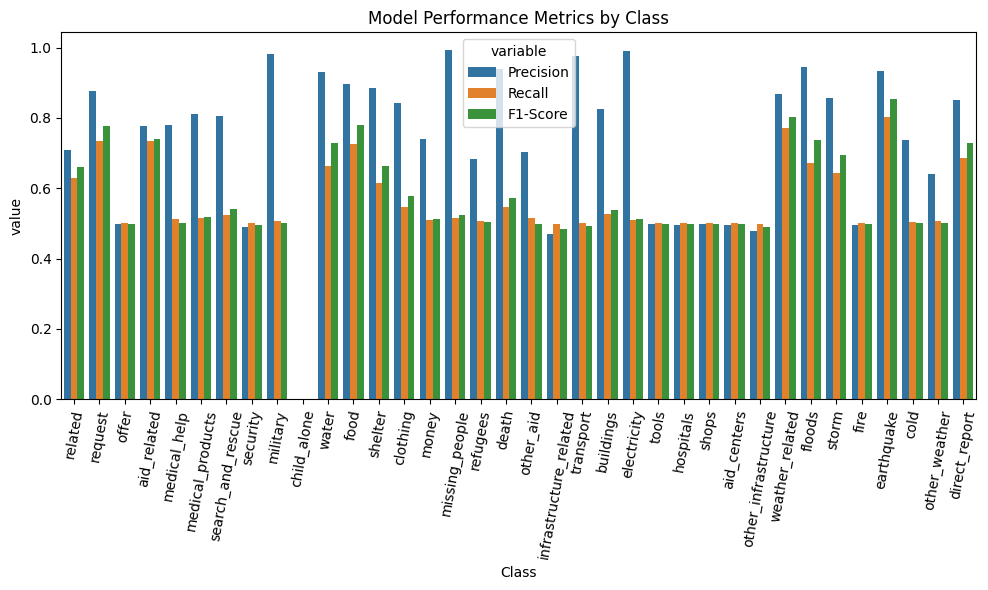

Current Working Directory: /Users/emmanuele/Desktop/IrisDrive/Upskilling/Data Science/Course Contents/Data Engineering/Capstone Project/disaster_response_pipeline_project/workspace
Model saved successfully as mock_classifier.pkl


In [49]:
db_path = '../data/DisasterResponse.db'
X, y, classes = load_data(
                        x_column_name="message",
                        y_start=4,
                        table_name="cleandata",
                        database_path=db_path
                    )
                                    
# Inspect the training dataset
data_audit_report = audit_data(X, y, classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Inspect the split training and test dataset   
data_audit_report = audit_data(X_train, y_train, classes, X_test, y_test)

model = mock_model()
model.fit(X_train, y_train)

# ensure the outputs of each transformer is of the shape we expect.
output_data = inspect_pipeline(model, X_train)

# evaluate the model with test data.
y_pred, metrics_df = model_evaluator(model, X_test, y_test, classes) 

model_path = 'mock_classifier.pkl'
save_model(model, model_path)

In [50]:
model

Pipeline(steps=[('vectorize',
                 CountVectorizer(tokenizer=<function tokenize at 0x1659834c0>)),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])

In [74]:
def load_model(filepath):
    """Load ML model using joblib"""
    try:
        with open(filepath, 'rb') as f:
            model = joblib.load(f)
        print(f"Model loaded successfully from {filepath}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

In [78]:
model_filepath = "mock-classifier.pkl"
save_model(model, model_filepath)

Current Working Directory: /Users/emmanuele/Desktop/IrisDrive/Upskilling/Data Science/Course Contents/Data Engineering/Capstone Project/disaster_response_pipeline_project/workspace
Model saved successfully as mock-classifier.pkl


In [79]:
loaded_model = load_model(model_filepath)
print(loaded_model)

Model loaded successfully from mock-classifier.pkl
Pipeline(steps=[('vectorize',
                 CountVectorizer(tokenizer=<function tokenize at 0x102f05da0>)),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])


In [71]:
# ensure the outputs of each transformer is of the shape we expect.
output_data = inspect_pipeline(loaded_model, X_train)

----------------------------------------------------------------------------------------------------
MODEL PERFORMANCE EVALUATION
----------------------------------------------------------------------------------------------------
Non-ML Pipeline Model
----------------------------------------------------------------------------------------------------
Overall Sample-wise Accuracy: 0.946
----------------------------------------------------------------------------------------------------

Summary of all metrics:
----------------------------------------------------------------------------------------------------


,category,accuracy,Precision,Recall,F1-Score
0,related,0.833,0.710,0.629,0.661
1,request,0.894,0.875,0.733,0.778
2,offer,0.996,0.498,0.500,0.499
3,aid_related,0.763,0.777,0.734,0.740
4,medical_help,0.914,0.781,0.511,0.501
5,medical_products,0.952,0.810,0.515,0.518
6,search_and_rescue,0.974,0.806,0.525,0.540
7,security,0.982,0.491,0.500,0.495
8,military,0.966,0.983,0.505,0.502
9,child_alone,1.000,NaN,NaN,NaN


Detailed classification report per class
----------------------------------------------------------------------------------------------------

Detailed metrics for related:


,precision,recall,f1-score,support
0,0.718,0.512,0.598,1233.000
1,0.859,0.938,0.897,3963.000
2,0.553,0.438,0.488,48.000
accuracy,0.833,0.833,0.833,0.833
macro avg,0.710,0.629,0.661,5244.000
weighted avg,0.823,0.833,0.822,5244.000



Detailed metrics for request:


,precision,recall,f1-score,support
0,0.898,0.982,0.938,4313.000
1,0.853,0.484,0.618,931.000
accuracy,0.894,0.894,0.894,0.894
macro avg,0.875,0.733,0.778,5244.000
weighted avg,0.890,0.894,0.881,5244.000



Detailed metrics for offer:


,precision,recall,f1-score,support
0,0.996,1.000,0.998,5222.000
1,0.000,0.000,0.000,22.000
accuracy,0.996,0.996,0.996,0.996
macro avg,0.498,0.500,0.499,5244.000
weighted avg,0.992,0.996,0.994,5244.000



Detailed metrics for aid_related:


,precision,recall,f1-score,support
0,0.745,0.906,0.818,3072.000
1,0.809,0.561,0.662,2172.000
accuracy,0.763,0.763,0.763,0.763
macro avg,0.777,0.734,0.740,5244.000
weighted avg,0.771,0.763,0.753,5244.000



Detailed metrics for medical_help:


,precision,recall,f1-score,support
0,0.914,0.999,0.955,4786.000
1,0.647,0.024,0.046,458.000
accuracy,0.914,0.914,0.914,0.914
macro avg,0.781,0.511,0.501,5244.000
weighted avg,0.891,0.914,0.875,5244.000



Detailed metrics for medical_products:


,precision,recall,f1-score,support
0,0.953,0.999,0.975,4989.000
1,0.667,0.031,0.060,255.000
accuracy,0.952,0.952,0.952,0.952
macro avg,0.810,0.515,0.518,5244.000
weighted avg,0.939,0.952,0.931,5244.000



Detailed metrics for search_and_rescue:


,precision,recall,f1-score,support
0,0.975,0.999,0.987,5105.000
1,0.636,0.050,0.093,139.000
accuracy,0.974,0.974,0.974,0.974
macro avg,0.806,0.525,0.540,5244.000
weighted avg,0.966,0.974,0.963,5244.000



Detailed metrics for security:


,precision,recall,f1-score,support
0,0.982,1.000,0.991,5147.000
1,0.000,0.000,0.000,97.000
accuracy,0.982,0.982,0.982,0.982
macro avg,0.491,0.500,0.495,5244.000
weighted avg,0.963,0.982,0.972,5244.000



Detailed metrics for military:


,precision,recall,f1-score,support
0,0.966,1.000,0.983,5062.000
1,1.000,0.011,0.022,182.000
accuracy,0.966,0.966,0.966,0.966
macro avg,0.983,0.505,0.502,5244.000
weighted avg,0.967,0.966,0.949,5244.000



Detailed metrics for child_alone:

Found No true instances for child_alone. Ommitted from report


Detailed metrics for water:


,precision,recall,f1-score,support
0,0.960,0.998,0.978,4938.000
1,0.901,0.327,0.480,306.000
accuracy,0.959,0.959,0.959,0.959
macro avg,0.930,0.662,0.729,5244.000
weighted avg,0.956,0.959,0.949,5244.000



Detailed metrics for food:


,precision,recall,f1-score,support
0,0.937,0.991,0.963,4669.000
1,0.857,0.459,0.598,575.000
accuracy,0.932,0.932,0.932,0.932
macro avg,0.897,0.725,0.781,5244.000
weighted avg,0.928,0.932,0.923,5244.000



Detailed metrics for shelter:


,precision,recall,f1-score,support
0,0.932,0.996,0.963,4793.00
1,0.840,0.233,0.365,451.00
accuracy,0.930,0.930,0.930,0.93
macro avg,0.886,0.614,0.664,5244.00
weighted avg,0.924,0.930,0.912,5244.00



Detailed metrics for clothing:


,precision,recall,f1-score,support
0,0.987,0.999,0.993,5169.000
1,0.700,0.093,0.165,75.000
accuracy,0.986,0.986,0.986,0.986
macro avg,0.844,0.546,0.579,5244.000
weighted avg,0.983,0.986,0.981,5244.000



Detailed metrics for money:


,precision,recall,f1-score,support
0,0.978,1.000,0.989,5129.000
1,0.500,0.017,0.034,115.000
accuracy,0.978,0.978,0.978,0.978
macro avg,0.739,0.509,0.511,5244.000
weighted avg,0.968,0.978,0.968,5244.000



Detailed metrics for missing_people:


,precision,recall,f1-score,support
0,0.987,1.000,0.994,5175.000
1,1.000,0.029,0.056,69.000
accuracy,0.987,0.987,0.987,0.987
macro avg,0.994,0.514,0.525,5244.000
weighted avg,0.987,0.987,0.981,5244.000



Detailed metrics for refugees:


,precision,recall,f1-score,support
0,0.968,0.999,0.984,5075.000
1,0.400,0.012,0.023,169.000
accuracy,0.968,0.968,0.968,0.968
macro avg,0.684,0.506,0.503,5244.000
weighted avg,0.950,0.968,0.953,5244.000



Detailed metrics for death:


,precision,recall,f1-score,support
0,0.956,1.000,0.977,4991.000
1,0.920,0.091,0.165,253.000
accuracy,0.956,0.956,0.956,0.956
macro avg,0.938,0.545,0.571,5244.000
weighted avg,0.954,0.956,0.938,5244.000



Detailed metrics for other_aid:


,precision,recall,f1-score,support
0,0.872,0.995,0.930,4554.000
1,0.533,0.035,0.065,690.000
accuracy,0.869,0.869,0.869,0.869
macro avg,0.703,0.515,0.497,5244.000
weighted avg,0.827,0.869,0.816,5244.000



Detailed metrics for infrastructure_related:


,precision,recall,f1-score,support
0,0.938,0.999,0.967,4918.000
1,0.000,0.000,0.000,326.000
accuracy,0.937,0.937,0.937,0.937
macro avg,0.469,0.499,0.484,5244.000
weighted avg,0.879,0.937,0.907,5244.000



Detailed metrics for transport:


,precision,recall,f1-score,support
0,0.955,1.000,0.977,5005.000
1,1.000,0.004,0.008,239.000
accuracy,0.955,0.955,0.955,0.955
macro avg,0.977,0.502,0.493,5244.000
weighted avg,0.957,0.955,0.933,5244.000



Detailed metrics for buildings:


,precision,recall,f1-score,support
0,0.952,0.999,0.975,4981.000
1,0.700,0.053,0.099,263.000
accuracy,0.951,0.951,0.951,0.951
macro avg,0.826,0.526,0.537,5244.000
weighted avg,0.940,0.951,0.931,5244.000



Detailed metrics for electricity:


,precision,recall,f1-score,support
0,0.980,1.000,0.990,5139.00
1,1.000,0.019,0.037,105.00
accuracy,0.980,0.980,0.980,0.98
macro avg,0.990,0.510,0.514,5244.00
weighted avg,0.981,0.980,0.971,5244.00



Detailed metrics for tools:


,precision,recall,f1-score,support
0,0.995,1.000,0.998,5219.000
1,0.000,0.000,0.000,25.000
accuracy,0.995,0.995,0.995,0.995
macro avg,0.498,0.500,0.499,5244.000
weighted avg,0.990,0.995,0.993,5244.000



Detailed metrics for hospitals:


,precision,recall,f1-score,support
0,0.990,1.00,0.995,5189.00
1,0.000,0.00,0.000,55.00
accuracy,0.990,0.99,0.990,0.99
macro avg,0.495,0.50,0.497,5244.00
weighted avg,0.979,0.99,0.984,5244.00



Detailed metrics for shops:


,precision,recall,f1-score,support
0,0.994,1.000,0.997,5215.000
1,0.000,0.000,0.000,29.000
accuracy,0.994,0.994,0.994,0.994
macro avg,0.497,0.500,0.499,5244.000
weighted avg,0.989,0.994,0.992,5244.000



Detailed metrics for aid_centers:


,precision,recall,f1-score,support
0,0.990,1.00,0.995,5189.00
1,0.000,0.00,0.000,55.00
accuracy,0.990,0.99,0.990,0.99
macro avg,0.495,0.50,0.497,5244.00
weighted avg,0.979,0.99,0.984,5244.00



Detailed metrics for other_infrastructure:


,precision,recall,f1-score,support
0,0.958,0.999,0.978,5025.000
1,0.000,0.000,0.000,219.000
accuracy,0.957,0.957,0.957,0.957
macro avg,0.479,0.500,0.489,5244.000
weighted avg,0.918,0.957,0.937,5244.000



Detailed metrics for weather_related:


,precision,recall,f1-score,support
0,0.854,0.970,0.908,3776.000
1,0.882,0.572,0.694,1468.000
accuracy,0.859,0.859,0.859,0.859
macro avg,0.868,0.771,0.801,5244.000
weighted avg,0.862,0.859,0.848,5244.000



Detailed metrics for floods:


,precision,recall,f1-score,support
0,0.943,0.998,0.970,4800.000
1,0.944,0.345,0.505,444.000
accuracy,0.943,0.943,0.943,0.943
macro avg,0.944,0.671,0.737,5244.000
weighted avg,0.943,0.943,0.930,5244.000



Detailed metrics for storm:


,precision,recall,f1-score,support
0,0.933,0.992,0.962,4766.000
1,0.779,0.295,0.428,478.000
accuracy,0.928,0.928,0.928,0.928
macro avg,0.856,0.643,0.695,5244.000
weighted avg,0.919,0.928,0.913,5244.000



Detailed metrics for fire:


,precision,recall,f1-score,support
0,0.990,1.00,0.995,5190.00
1,0.000,0.00,0.000,54.00
accuracy,0.990,0.99,0.990,0.99
macro avg,0.495,0.50,0.497,5244.00
weighted avg,0.980,0.99,0.985,5244.00



Detailed metrics for earthquake:


,precision,recall,f1-score,support
0,0.960,0.993,0.977,4742.000
1,0.906,0.614,0.732,502.000
accuracy,0.957,0.957,0.957,0.957
macro avg,0.933,0.803,0.854,5244.000
weighted avg,0.955,0.957,0.953,5244.000



Detailed metrics for cold:


,precision,recall,f1-score,support
0,0.977,1.000,0.988,5121.000
1,0.500,0.008,0.016,123.000
accuracy,0.977,0.977,0.977,0.977
macro avg,0.738,0.504,0.502,5244.000
weighted avg,0.966,0.977,0.965,5244.000



Detailed metrics for other_weather:


,precision,recall,f1-score,support
0,0.949,0.998,0.973,4972.000
1,0.333,0.015,0.028,272.000
accuracy,0.947,0.947,0.947,0.947
macro avg,0.641,0.507,0.501,5244.000
weighted avg,0.917,0.947,0.924,5244.000



Detailed metrics for direct_report:


,precision,recall,f1-score,support
0,0.870,0.981,0.922,4227.000
1,0.832,0.393,0.534,1017.000
accuracy,0.867,0.867,0.867,0.867
macro avg,0.851,0.687,0.728,5244.000
weighted avg,0.863,0.867,0.847,5244.000


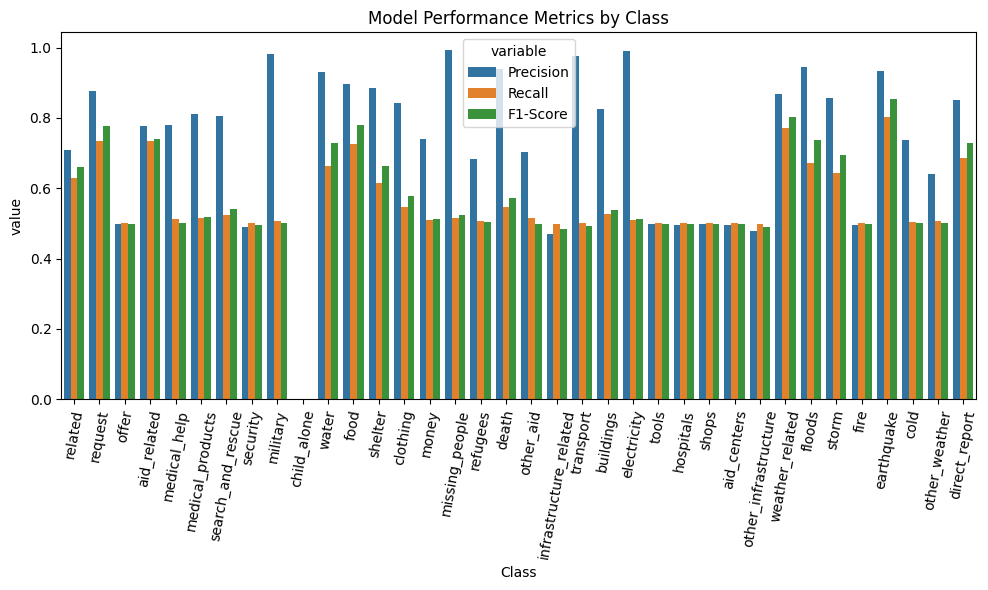

In [72]:
y_pred, metrics_df = model_evaluator(loaded_model, X_test, y_test, classes)